In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

import emcee
from scipy.optimize import minimize
from scipy.stats import t, norm

In [2]:
from surp import subgiants
import surp
import vice
from surp import gce_math as gcem
import arya

import sys

/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
from singlezone import run_singlezone, exp_sfh

In [4]:
import warnings;
warnings.filterwarnings("ignore")

In [5]:
y_scale = 0.6# 0.712

mw = {}
gse = dict(eta=y_scale * 9.56, t_end=10.73, tau_star=26.60, tau_sfh=2.18, sfh=exp_sfh(None), mode="ifr")
wukong = dict(eta=y_scale * 48, t_end=3.4, tau_star=45, tau_sfh=3.08, sfh=exp_sfh(None), mode="ifr")

In [6]:
def calc_model(**params):
    sz, h = run_singlezone(**params)
    
    return h.O_H, h.C_O, h.sfr

In [7]:
def plot_sz(label="", **kwargs,):
    x, y, w = calc_model(**kwargs)
    plt.scatter(x, y, s=w, label=label)
    plt.xlabel("[Mg/Fe]")
    plt.ylabel("[C/Mg]")
    arya.Legend(loc=-1, color_only=True)

In [8]:
amarsi19 = pd.read_csv(surp.DATA_DIR + "amarsi_19.tsv", delimiter="\t *", comment="#", skiprows=[62, 63],)

amarsi19["FE_H"] = amarsi19["[Fe/H]3L"]
amarsi19["FE_H_err"] = amarsi19["e_[Fe/H]3L"]

amarsi19["O_H"] = amarsi19["[O/H]3N"]
amarsi19["O_H_err"] = amarsi19["e_[O/H]3N"]

amarsi19["C_H"] = amarsi19["[C/H]3N"]
amarsi19["C_H_err"] = amarsi19["e_[C/H]3N"]

amarsi19["C_O"] = amarsi19["C_H"] - amarsi19["O_H"] 
amarsi19["C_O_err"] = amarsi19["O_H_err"] + amarsi19["C_H_err"] 

amarsi19["O_FE"] = amarsi19["O_H"] - amarsi19["[Fe/H]3L"]
amarsi19["O_FE_err"] = amarsi19["e_[Fe/H]3L"] + amarsi19["O_H_err"]

amarsi19_sun = amarsi19.iloc[151]
amarsi19.drop(index=151, inplace=True)

In [9]:
def plot_obs(**kwargs):
    plt.scatter(amarsi19.O_H, amarsi19.C_O, zorder=-1, s=0.1, label="amarsi+19")
    

In [10]:
def plot_all():
    plot_sz(label="solar")
    plot_sz(**gse, label="gse")
    plot_sz(**wukong, label="wukong")
    plot_obs()
    arya.Legend(color_only=True)
    plt.xlim(-4)

In [11]:
models = "../models/"

In [12]:
def get_y_params(name):
    return surp.YieldParams.from_file("../models/" + name + "/yield_params.json")

In [13]:
y_fiducial = get_y_params('fiducial')

In [14]:
y_lin = get_y_params('C11_f0.2_BiLogLin')

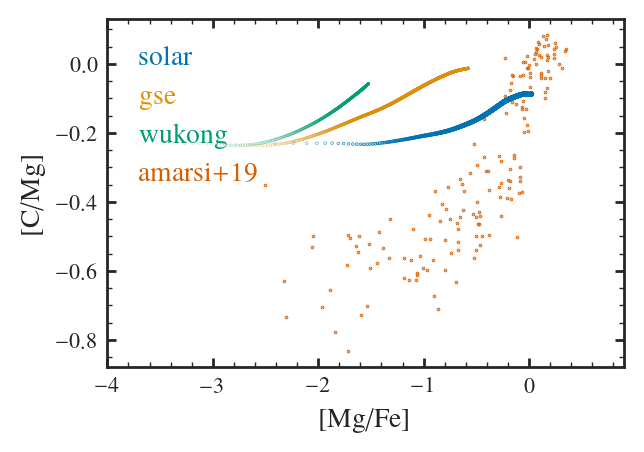

In [15]:
surp.set_yields(y_fiducial, verbose=False)
plot_all()

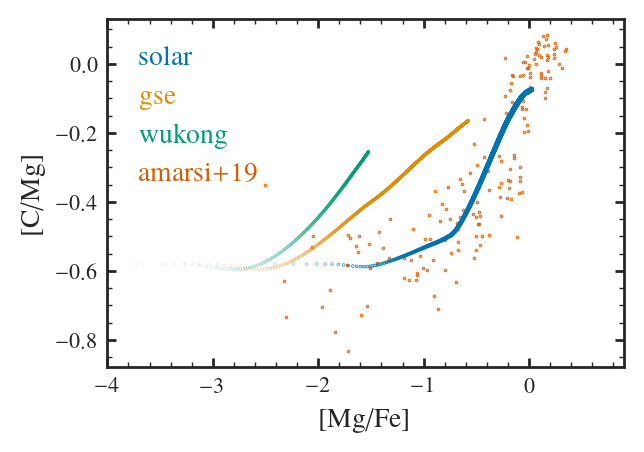

In [16]:
surp.set_yields(y_lin, verbose=False)
plot_all()

## piecewise chaos 

In [17]:
print(vice.yields.ccsne.settings["c"])

2.30e-03 + 1.62e-03 [M/H] or 8.67e-04, else


In [18]:
m_h_0 = (0.867 - 2.30) / 1.62

In [19]:
gcem.MH_to_Z(m_h_0)

0.0020871424029988653

In [20]:
y_piecewise = surp.yield_models.Piecewise_CC(
    [2e-3, 8.67e-4, 2.30e-3],
    [0, 0, 1.62e-3],
    [1.6e-5, 0.0021])


In [21]:
vice.yields.ccsne.settings["c"] = y_piecewise

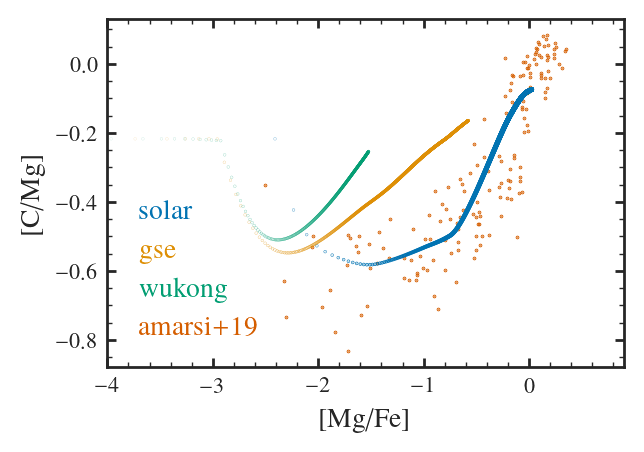

In [22]:
plot_all()

In [23]:
y_mg = vice.yields.ccsne.settings["mg"]

In [24]:
y_spw = surp.yield_models.Piecewise_CC(
    [3*y_mg, 1*y_mg, 4*y_mg, 4*y_mg],
    [0, 0, 0, 2.5*y_mg],
    [1.6e-5, 0.006, 0.016])

In [25]:
vice.yields.ccsne.settings["c"] = y_spw

In [26]:
surp.set_yields(get_y_params("C11_alpha_agb1.0_m_factor0.5"), verbose=False)
vice.yields.ccsne.settings["c"] = y_spw

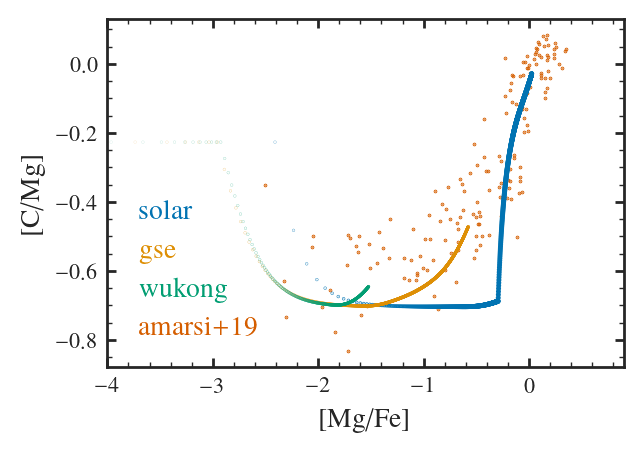

In [27]:
plot_all()

Text(0, 0.5, '$y_{\\rm C}^{\\rm CC}$')

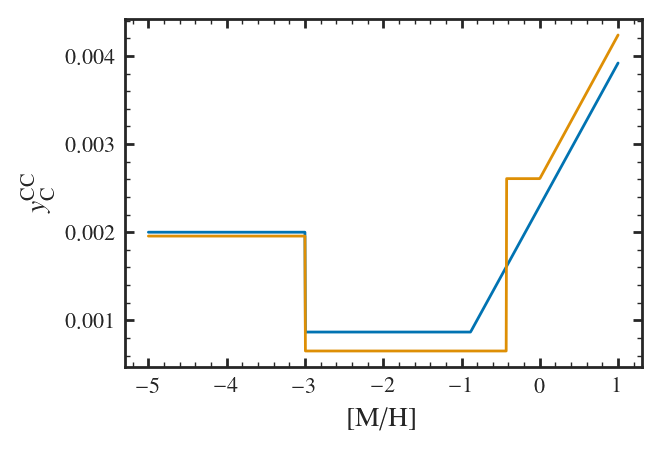

In [29]:

x = np.linspace(-5, 1, 1000)
z = gcem.MH_to_Z(x)
y = [y_piecewise(zz) for zz in z]

plt.plot(x, y)

y = [y_spw(zz) for zz in z]

plt.plot(x, y)

plt.xlabel("[M/H]")
plt.ylabel(r"$y_{\rm C}^{\rm CC}$")

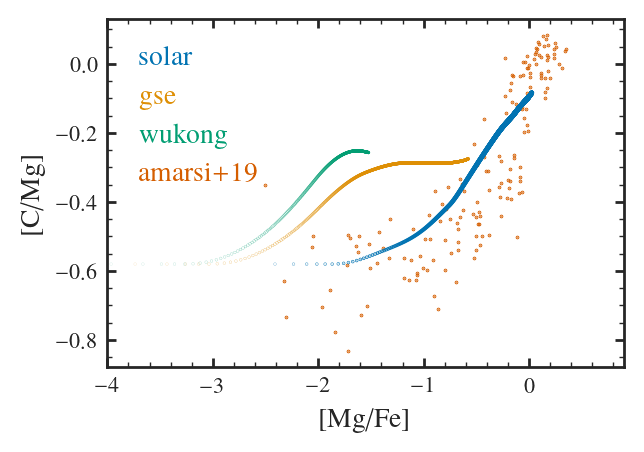

In [115]:
surp.set_yields(get_y_params("C11_f0.2_m_factor1.5"), verbose=False)
plot_all()

In [120]:
print(vice.yields.ccsne.settings["c"])

3.69e-03 MH^2 + 1.81e-03 MH + 2.37e-03


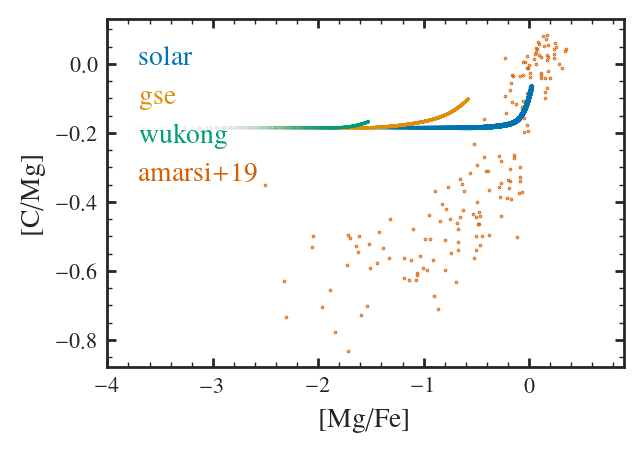

In [119]:
surp.set_yields(get_y_params("C11_alpha_agb1.0_m_factor0.5"), verbose=False)
plot_all()